# Statistical Tests Notebook

## TO DO:
- ~~LB: Esportare i T90 dei simulati su file di testo usando il  metodo della classe;~~
- ~~LB: Esportare gli errori delle curve di luce simulate (radice quadrata dei conteggi con il background);~~
- ~~AF: Rifare tutto solo con i long (rimuovere tutti i GRB con T90 < 2s);~~
- AF: Tagliare i grb con max(conteggi) sotto a 200;
- AF: Sostituire il plot del T90 con quello del 20%;
- AF: Rebinnare la curva mediata -> rebinno bin fino a che il contenuto del bin ha un numero di conteggi > `n_sigma * `bin_error`, con `n_sigma = 1`;
- Autocorrelazione: in attesa di news;
- Chiedere ad Anastasia perchè nella funzione `_restrore_lc()` manca il fattore ampl che aveva usato prima. Chiedere anche come salvare il file `yaml`;




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

SEED=42
np.random.seed(SEED)

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%config InlineBackend.figure_format='retina' # very useful command for high-res images

In [3]:
# set the username for the path of the files:
user='LB'
#user='AF'

if user=='LB':
    file_path='/home/lorenzo/Desktop/Astrophysics/PYTHON/DATA/CGRO_BATSE/'
    sim_path ='/home/lorenzo/git/lc_pulse_avalanche/simulations/'
elif user=='AF':
    file_path='E:/grb_to_test/CGRO_BATSE/'
    sim_path ='E:/grb_to_test/simulations/'
else:
    raise ValueError('Assign to the variable "user" a correct username!')

In [4]:
class GRB:
    def __init__(self, grb_name, times, counts, errs, t90):
        self.name   = grb_name
        self.times  = times
        self.counts = counts
        self.errs   = errs
        self.t90    = t90

### T90 Calculation <br>
__T90 definition__ <br> 
The 90% duration of the burst in seconds. T90 measures the duration of the time interval during which 90% of the total observed counts have been detected. The start of the T90 interval is defined by the time at which 5% of the total counts have been detected, and the end of the T90 interval is defined by the time at which 95% of the total counts have been detected (definition taken [here](https://heasarc.gsfc.nasa.gov/grbcat/notes.html)).


NB: For BATSE, all the T90s of the GRBs have been already evaluated by Cristiano. The file is uploaded on the repository for easier access (file path on Gravity: `/astrodata/guidorzi/CGRO_BATSE/T90_full.dat`).


#### T90 Calculation function
A function to evaluate the T90 of a GRB given 
1. times of the lightcurve bins, and
2. counts per bin 

In [5]:
def evaluateT90(times, counts):
    cumulative_counts = np.cumsum(counts)
    total_counts = cumulative_counts[-1]
    t_5_counts   = 0.05 * total_counts
    t_95_counts  = 0.95 * total_counts
    t_5_index    = np.where(cumulative_counts <=  t_5_counts )[0][-1]
    t_95_index   = np.where(cumulative_counts >=  t_95_counts)[0][0]
    t_5  = times[t_5_index]
    t_95 = times[t_95_index]
    t90  = t_95-t_5
    return t90


## Load BASTE Data

#### Data Selection 
Select only the GRB for which we still have data points after 150 s from the burst

In [6]:
#BATSE observations' parametes
t_i=0          # [s]
t_f=150        # [s]
bin_time=0.064 # [s] temporal bins for BATSE
test_times=np.arange(t_i, t_f, bin_time)

In [7]:
#List containing all the GRBs which passed the selection
grb_list_batse     = []
all_grb_list_batse = [grb_num.rstrip('\n') for grb_num in open(file_path + 'alltrig_long.list').readlines()]
                      # removing the one already marked as shorts from the bunch
                      # [grb_num.rstrip('\n') for grb_num  in open(file_path + 'alltrig_short.list').readlines()]

#Loading t90 data
t90data = np.loadtxt(file_path+'T90_full.dat')

for grb_name in all_grb_list_batse:
    t90 = t90data[t90data[:,0] == float(grb_name),1]
    times, counts, errs = np.loadtxt(file_path+grb_name+'_all_bs.out', unpack=True)
    c_max   = np.max(counts)
    i_t_max = np.argmax(counts)
    counts_to_sum = counts[i_t_max:i_t_max + len(test_times)] / c_max
    if  not ( len(counts_to_sum) < len(test_times) or t90 <= 2.):
        grb = GRB(grb_name, times, counts, errs, t90)
        grb_list_batse.append(grb)
    

## Load Simulated Data
Select which simulated LCs to use and read the simulation files with the fluxes already evaluated

In [14]:
grb_sim_names = os.listdir(sim_path)
grb_list_sim  = []
for grb_file in grb_sim_names:
    grb_name = grb_file[grb_file.find('lc') + 2: grb_file.find('.txt')]
    times, counts, errs, t90 = np.loadtxt(sim_path + grb_file, unpack = True)
    t90 = t90[0]
    grb = GRB(grb_name, times, counts, errs, 0) # provisory set the value of t90 after loading the grb
    if (t90>2):
        grb.t90 = t90
        grb_list_sim.append(grb) 

simulations_file = sim_path + 'simulations.txt' # da cambiare con quello dentro l'hard disk
simulated_times, simulated_fluxes, sim_frms, sim_flux_cube  = np.loadtxt(simulations_file, unpack=True)

n_step_sim       = int(t_f/bin_time)
simulated_times  = np.array(simulated_times[:n_step_sim])
simulated_fluxes = np.array(simulated_fluxes[:n_step_sim])
sim_frms         = np.array(sim_frms[:n_step_sim])
sim_flux_cube    = np.array(sim_flux_cube[:n_step_sim])

In [15]:
filename='T90_full.dat'

grb_real, t90_real, t90_real_error = np.loadtxt(file_path+filename, unpack=True)
grb_real  = grb_real[t90_real > 2.]
t90_real  = t90_real[t90_real > 2.]
log10_t90 = np.log10(t90_real)

Evaluate T90 for the simulated GRBs

In [16]:
t90_sim = [grb.t90 for grb in grb_list_sim]

log10_t90_sim = np.log10(t90_sim)

In [17]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
# ax.set_axisbelow(True)
# #ax.grid(which = 'both')
# ax.set_ylabel('Number of events', size=20)
# ax.set_xlabel(r'$\log(T90)$ [s]', size=20)

# n, bins, patches = ax.hist(log10_t90, 
#                            bins=30,
#                            label = 'Data', density =True)
#                            #facecolor='lightgrey',
#                            #edgecolor='black')

# log10_t90_sim = log10_t90_sim[log10_t90_sim != -np.inf]
# n, bins, patches = ax.hist(log10_t90_sim, 
#                            bins=bins,
#                            alpha = 0.6,
#                            label = 'Simulated', density = True)
#                            #facecolor='lightgrey',
#                            #edgecolor='black')

# ax.xaxis.set_tick_params(labelsize=16)
# ax.yaxis.set_tick_params(labelsize=16)
# ax.legend()

## Test 2: Average Peak-Aligned Profiles

Following the technique described in [Mitranof et al., 1996](https://ui.adsabs.harvard.edu/abs/1996MmSAI..67..417M/abstract) and working on the time interval from 0 to 150 s from the peak (as done in [Stern et al., 1996](https://iopscience.iop.org/article/10.1086/310267)).

Since we only need the 'discharge' curve, and not the rise part, what we can do is trivially shift on the first position of the array the maximum value of the light curve, and then pad all the light curves to a fixed length (e.g., equal to the initial lenght of all the simulated lc). We can also skip the padding for the moment, and cut later on at the time instant we want.

In [18]:
########### TESTED on all the GRBs in alltrig_long.list and alltrig_short.list        ############

# small sample of GRBs, for tests:
#grb_list_batse = ["00105_all_bs.out","00107_all_bs.out","00108_all_bs.out","00109_all_bs.out","00110_all_bs.out"]

averaged_fluxes        = np.zeros_like(test_times)
averaged_fluxes_square = np.zeros_like(test_times)
averaged_fluxes_cube   = np.zeros_like(test_times)

for grb in grb_list_batse:
    c_max   = np.max(grb.counts)
    i_t_max = np.argmax(grb.counts)
    counts_to_sum = grb.counts[i_t_max:i_t_max + len(test_times)] / c_max

    averaged_fluxes        += counts_to_sum
    averaged_fluxes_square += counts_to_sum**2
    averaged_fluxes_cube   += counts_to_sum**3

averaged_fluxes        /= len(grb_list_batse)
averaged_fluxes_square /= len(grb_list_batse)
averaged_fluxes_cube   /= len(grb_list_batse)
averaged_fluxes_rms     = np.sqrt(averaged_fluxes_square - averaged_fluxes**2)

In [19]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
# ax.set_axisbelow(True)
# ax.set_ylabel('log <F/Fp>')
# ax.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=20)
# ax.set_ylabel(r'$\log \langle F/F_p\rangle$',  size=20)
# ax.plot(test_times**(1/3), np.log10(averaged_fluxes),  color = 'blue', label = r'Flux BATSE')
# ax.plot(simulated_times**(1/3), np.log10(simulated_fluxes),      color = 'red',   label = r'Flux simulated', alpha=0.7)

# ax.plot(test_times[1:]**(1/3), np.log10(averaged_fluxes_rms[1:]),  color = 'cyan', label = r'$F_{rms}$ BATSE', alpha=0.7)
# ax.plot(simulated_times[1:]**(1/3), np.log10(sim_frms[1:]),      color = 'brown',   label = r'$F_{rms}$ simulated', alpha=0.7)
# ax.legend(prop={'size':16})
# plt.show()

# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot()
# ax.set_axisbelow(True)
# ax.set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$', size=20)
# ax.set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$',  size=20)
# ax.plot(test_times**(1/3), np.log10(averaged_fluxes_cube), color = 'black', label = 'BATSE')
# ax.plot(simulated_times**(1/3), np.log10(sim_flux_cube),      color = 'red',   label = 'simulated', alpha=0.7)
# ax.legend(prop={'size':16})
# plt.show()

## Test 3: Autocorrelation

Following the technique described in [Link+93](https://ui.adsabs.harvard.edu/abs/1993ApJ...408L..81L/abstract). For a time lag $\tau$, the autocorrelation function is defined as

$$
    A(\tau)=\frac{\langle[s(t+\tau)-b][s(t)-b]\rangle_t}{\left\langle[s(t)-b]^2\right\rangle_t}
$$
where $s(t)$ is the intrinsic count rate due to the source (independent of photon counting statistics), $b$ is the background count rate, and $\langle\cdot\rangle_t$ denotes a time-average over the data interval. The measured count rate is $m(t)=s(t)+e(t)$, where $e(t)$ is the error. For a sufficiently long data set, the time average of $e$ vanishes; i.e., $\langle e(t)\rangle_t=0$. Assuming that the signal and noise are uncorrelated, i.e., $\langle s(t) e(t)\rangle_t=0$, we obtain
$$
\begin{aligned}
& A(\tau)=1 & (\tau=0) \\
& A(\tau)=\frac{\langle[m(t+\tau)-b][m(t)-b]\rangle_t}{\left\langle[m(t)-b]^2\right\rangle_t-\left\langle e(t)^2\right\rangle_t} & (\tau \neq 0) . \\
&
\end{aligned}
$$
For discretely sampled data in $N$ bins of equal size $\Delta t$, we express the autocorrelation function as a sum
$$
\begin{array}{rlr}
A(\tau) &= 1 & (\tau=0) \\
A(\tau) &= \frac{\sum_{i=1}^{N-u}\left(m_{i+u}-b\right)\left(m_i-b\right)}{\sum_{i=1}^N\left[\left(m_i-b\right)^2-e_i^2\right]} & (\tau \neq 0),
\end{array}
$$
where the lag is $\tau \equiv u \Delta t$.

- BOTH the autocorrelations were computed with err=0

In [30]:
# Limits the number of GRBs to use
N_LIM=1000 # len(grb_list_batse)

#Number of steps for ACF
steps = np.arange(int(t_f/bin_time))

#------------------------------------------------------------------------------#
# Evaluate ACF on the REAL GRBs
#------------------------------------------------------------------------------#
# acf_python = np.zeros_like(steps)
acf_link93 = np.zeros_like(steps)
for grb in grb_list_batse[:N_LIM]:
    counts = grb.counts
    errs   = grb.errs
    # Link+93
    #errs=0
    acf_link93 = acf_link93 + [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    # statsmodel
    #acf_python = acf_python + sm.tsa.acf(counts, nlags=len(steps)-1)
#------------------------------------------------------------------------------#
# Evaluate ACF on the SIMULATED GRBs
#------------------------------------------------------------------------------#
# sim_acf_python = np.zeros_like(steps)
sim_acf_link93 = np.zeros_like(steps)
for grb in grb_list_sim[:N_LIM]:
    # Link+93
    counts = grb.counts
    errs   = grb.errs
    sim_acf_link93 = sim_acf_link93 + [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    # statsmodel
    #sim_acf_python = sim_acf_python + sm.tsa.acf(counts, nlags=len(steps)-1)
#------------------------------------------------------------------------------#
#sim_acf_python   /= N_LIM
acf_link93        /= N_LIM
sim_acf_link93    /= N_LIM
sim_acf_link93[0]  = 1
acf_link93[0]      = 1

#### Plots

/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/home/lorenzo/miniconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


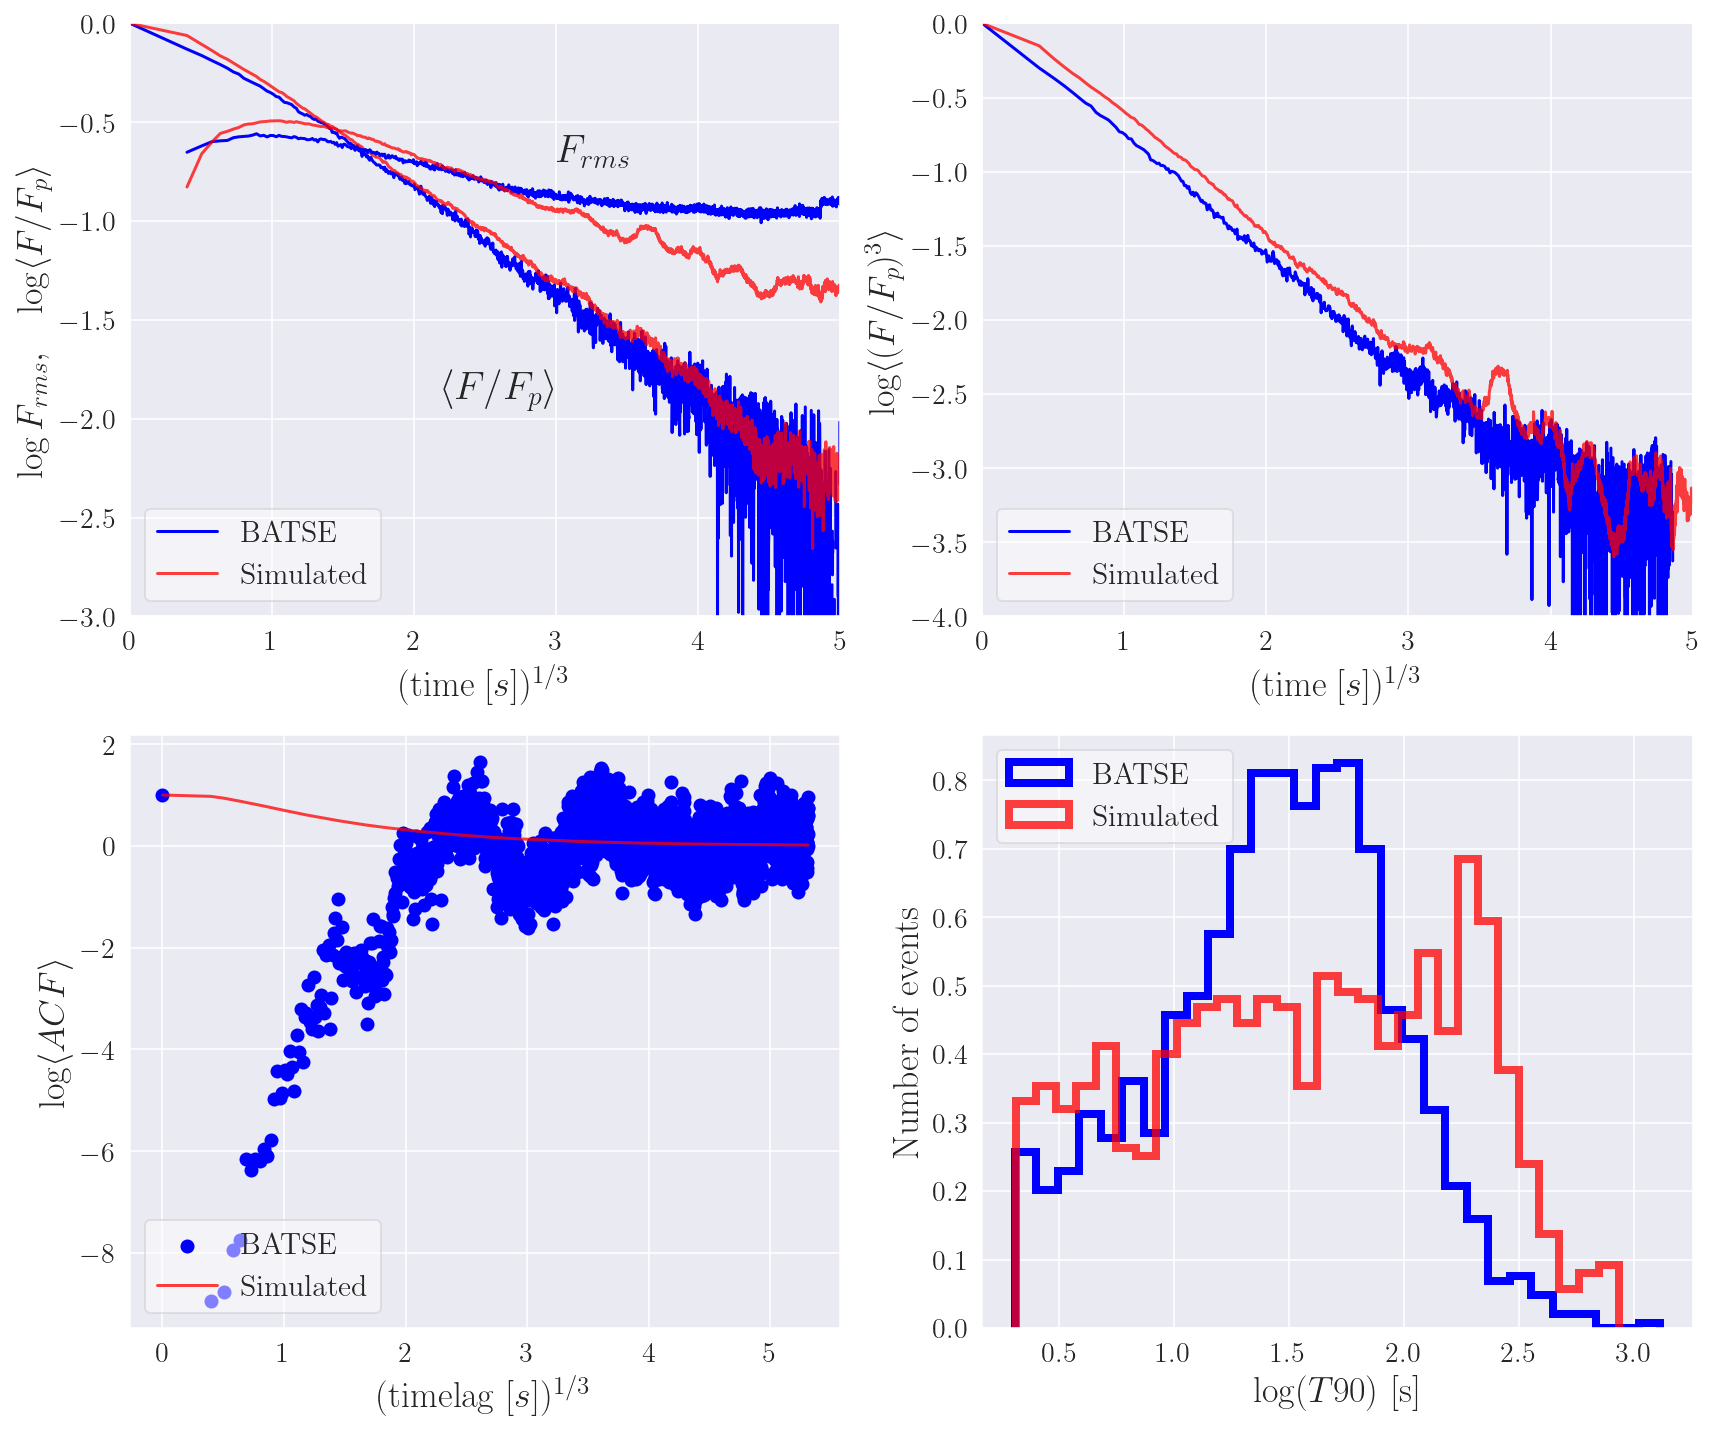

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(14,12))

#------------------------------------------------------------------------------#

ax[0,0].set_axisbelow(True)
ax[0,0].set_ylabel('log <F/Fp>')
ax[0,0].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',                    size=18)
ax[0,0].set_ylabel(r'$\log F_{rms},\quad \log \langle F/F_p\rangle$',  size=18)
ax[0,0].plot(test_times**(1/3),          np.log10(averaged_fluxes),         color = 'b', alpha=1.00, label = r'BATSE')
ax[0,0].plot(simulated_times**(1/3),     np.log10(simulated_fluxes),        color = 'r', alpha=0.75, label = r'Simulated')
ax[0,0].plot(test_times[1:]**(1/3),      np.log10(averaged_fluxes_rms[1:]), color = 'b', alpha=1.00)
ax[0,0].plot(simulated_times[1:]**(1/3), np.log10(sim_frms[1:]),            color = 'r', alpha=0.75)
ax[0,0].set_xlim(0,5)
ax[0,0].set_ylim(-3,0)
ax[0,0].text(3,   -0.7, r'$F_{rms}$',              fontsize=20)
ax[0,0].text(2.2, -1.9, r'$\langle F/F_p\rangle$', fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=14)
ax[0,0].yaxis.set_tick_params(labelsize=14)
ax[0,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#

ax[0,1].set_axisbelow(True)
ax[0,1].set_xlabel(r'$(\mathrm{time}\ [s])^{1/3}$',      size=18)
ax[0,1].set_ylabel(r'$\log \langle (F/F_p)^3 \rangle$',  size=18)
ax[0,1].plot(test_times**(1/3),      np.log10(averaged_fluxes_cube), color='b', label='BATSE')
ax[0,1].plot(simulated_times**(1/3), np.log10(sim_flux_cube),        color='r', label='Simulated', alpha=0.75)
ax[0,1].set_xlim(0,5)
ax[0,1].set_ylim(-4,0)
ax[0,1].xaxis.set_tick_params(labelsize=14)
ax[0,1].yaxis.set_tick_params(labelsize=14)
ax[0,1].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#

ax[1,0].scatter((steps*bin_time)**(1/3), (acf_link93),  color='b', label='BATSE')
ax[1,0].plot((steps*bin_time)**(1/3), (sim_acf_link93), color='r', label='Simulated', alpha=0.75)
#ax[1,0].scatter((steps*bin_time)**(1/3), np.log10(acf_link93),     color='b', label='BATSE')
#ax[1,0].plot((steps*bin_time)**(1/3),    np.log10(sim_acf_link93), color='r', label='Simulated', alpha=0.75)
ax[1,0].set_xlabel(r'$(\mathrm{timelag}\ [s])^{1/3}$', size=18)
ax[1,0].set_ylabel(r'$\log \langle ACF \rangle$',                     size=18)
#ax[1,0].set_xlim(0,5)
#ax[1,0].set_ylim(-2,0.2)
ax[1,0].xaxis.set_tick_params(labelsize=14)
ax[1,0].yaxis.set_tick_params(labelsize=14)
ax[1,0].legend(prop={'size':15}, loc="lower left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#

ax[1,1].set_axisbelow(True)
ax[1,1].set_ylabel('Number of events', size=18)
ax[1,1].set_xlabel(r'$\log(T90)$ [s]', size=18)

n_bins=30
n, bins, patches = ax[1,1].hist(x=log10_t90, 
                                bins=n_bins,
                                alpha=1.00,
                                label='BATSE', 
                                color='b',
                                histtype='step',
                                linewidth=4,
                                density=True)

n, bins, patches = ax[1,1].hist(x=log10_t90_sim, 
                                bins=n_bins,
                                alpha=0.75,
                                label='Simulated', 
                                color='r',
                                histtype='step',
                                linewidth=4,
                                density=True)
                         
#ax[1,1].set_xlim(-2,3)
#ax[1,1].set_ylim(0,30)
ax[1,1].xaxis.set_tick_params(labelsize=14)
ax[1,1].yaxis.set_tick_params(labelsize=14)
ax[1,1].legend(prop={'size':15}, loc="upper left", facecolor='white', framealpha=0.5)

#------------------------------------------------------------------------------#

plt.show()

# DEBUG

In [55]:
mean_value=0
for i, grb in enumerate(grb_list_batse[500:1000]):
    times=grb.times
    counts=grb.counts
    errs=grb.errs
    #plt.errorbar(times[::100], 
    #             counts[::100], 
    #             yerr=errs[::100],
    #             ecolor='r', 
    #             marker='.',
    #             color='b')
    #plt.show()    
    acf_link93 = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
    mean_value+=acf_link93[1]
    if(acf_link93[1]<-50):
        print(acf_link93[1], i)
    #print(acf_link93[1], i)
print('mean = ', mean_value/100)

-8658.77467842239 95
-1606.1551962187666 164
-82.18992707329079 445
-93.03655638126973


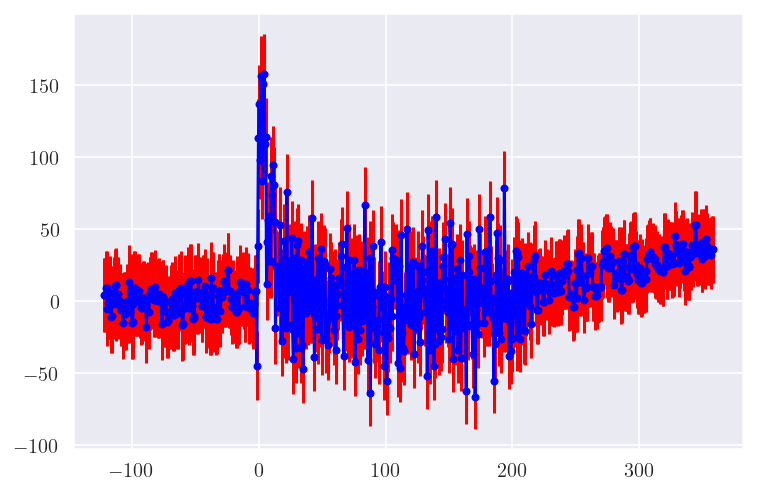

2.727378286490235 164


In [57]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==164: # 187
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        plt.errorbar(times[::10], 
                     counts[::10], 
                     yerr=errs[::10],
                     ecolor='r', 
                     marker='.',
                     color='b')
        plt.show()    
        acf_link93 = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93[1], i)
    else:
        pass

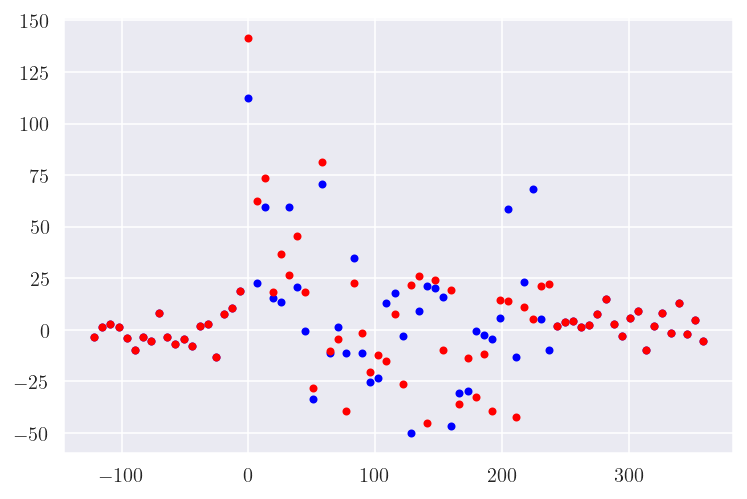

-225.07361124631066 187


In [54]:
for i, grb in enumerate(grb_list_batse[:1000]):
    if i==187:
        times=grb.times
        counts=grb.counts
        errs=grb.errs
        counts_u1=np.roll(counts,-1)
        plt.scatter(times[::100], 
                    counts[::100], 
                    color='b',
                    marker='.')
        plt.scatter(times[::100], 
                    counts_u1[::100], 
                    color='r',
                    marker='.')
        plt.show()    
        acf_link93 = [np.sum((np.roll(counts, u) * counts)[u:]) / np.sum(counts**2 - errs**2) for u in range(len(steps))]
        print(acf_link93[1], i)
    else:
        pass

(array([197., 423., 329., 206., 102.,  69.,  30.,  17.,   7.,   2.]),
 array([1.92541524, 2.19868818, 2.47196111, 2.74523405, 3.01850699,
        3.29177993, 3.56505287, 3.83832581, 4.11159875, 4.38487168,
        4.65814462]),
 <BarContainer object of 10 artists>)

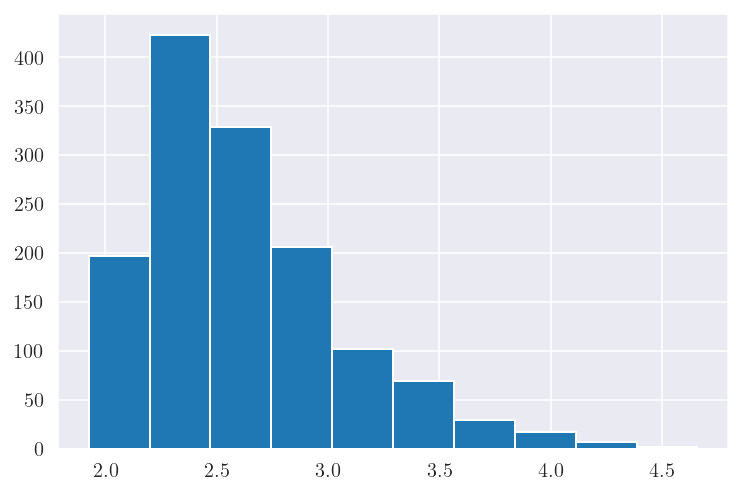

In [61]:
maxlist =[]
for i, grb in enumerate(grb_list_batse):
    maxlist.append(np.max(grb.counts))

plt.hist(np.log10(maxlist));